In [5]:
import umap
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from src.models.spectrogram_vae import SpectrogramVAE
from src.utils import audio_to_spectrogram
from src.plot_utils import *

import seaborn as sns

In [6]:
sns.set(style='white')

In [7]:
DAFX_TO_USE = [
    # 'mda MultiBand',
    # 'clean',
    'mda Delay',
    'mda Overdrive',
    'mda Ambience',
    'mda RingMod',
    # 'mda Leslie',
    'mda Combo',
    # 'mda Thru-Zero Flanger',
    # 'mda Loudness',
    # 'mda Limiter',
    'mda Dynamics',
]

In [8]:
NUM_EXAMPLES = 5_000
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_spectrogram_vae/hdx3y4ly/checkpoints/epoch=169-step=35530.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
model = SpectrogramVAE.load_from_checkpoint(CHECKPOINT).to(DEVICE)
model.eval()

SpectrogramVAE(
  (encoder_conv): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (mu): Linear(in_features=37152, out_features=128, bias=True)
  (log_var): Linear(in_features=37152, 

In [10]:
from tqdm import tqdm

embeddings = []

for fx in DAFX_TO_USE:
    dafx = dafx_from_name(fx)
    dataset = get_audio_dataset(dafx, num_examples_per_epoch=NUM_EXAMPLES, effect_audio=True, dummy_setting=True)

    for x in tqdm(dataset):
        X = audio_to_spectrogram(signal=x,
                                 n_fft=model.hparams.n_fft,
                                 hop_length=model.hparams.hop_length,
                                 window_size=model.hparams.window_size).to(DEVICE)

        _, _, _, z = model(X)

        embeddings.append(z.cpu().detach().numpy())

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 17279.90it/s]



Loaded 88 files for train = 66.89 hours.


100%|█████████████████████████████████████████| 88/88 [00:00<00:00, 1966.00it/s]



Loaded 88 files for train = 66.89 hours.


100%|█████████████████████████████████████████| 88/88 [00:00<00:00, 2185.06it/s]



Loaded 88 files for train = 66.89 hours.


100%|█████████████████████████████████████████| 88/88 [00:00<00:00, 2215.33it/s]



Loaded 88 files for train = 66.89 hours.


100%|█████████████████████████████████████████| 88/88 [00:00<00:00, 2322.00it/s]



Loaded 88 files for train = 66.89 hours.


100%|█████████████████████████████████████████| 88/88 [00:00<00:00, 2321.95it/s]



Loaded 88 files for train = 66.89 hours.


100%|██████████| 5000/5000 [00:28<00:00, 177.80it/s]


In [11]:
data = np.array(embeddings).squeeze()

In [12]:
data.shape

(30000, 128)

In [13]:
umap_data = umap.UMAP(min_dist=0.2, metric='cosine').fit_transform(data)
umap_labels = np.concatenate([[fx]*NUM_EXAMPLES for fx in DAFX_TO_USE]).squeeze()

In [14]:
plot_labels = LabelEncoder().fit_transform(umap_labels)

In [15]:
num_fx = len(DAFX_TO_USE)

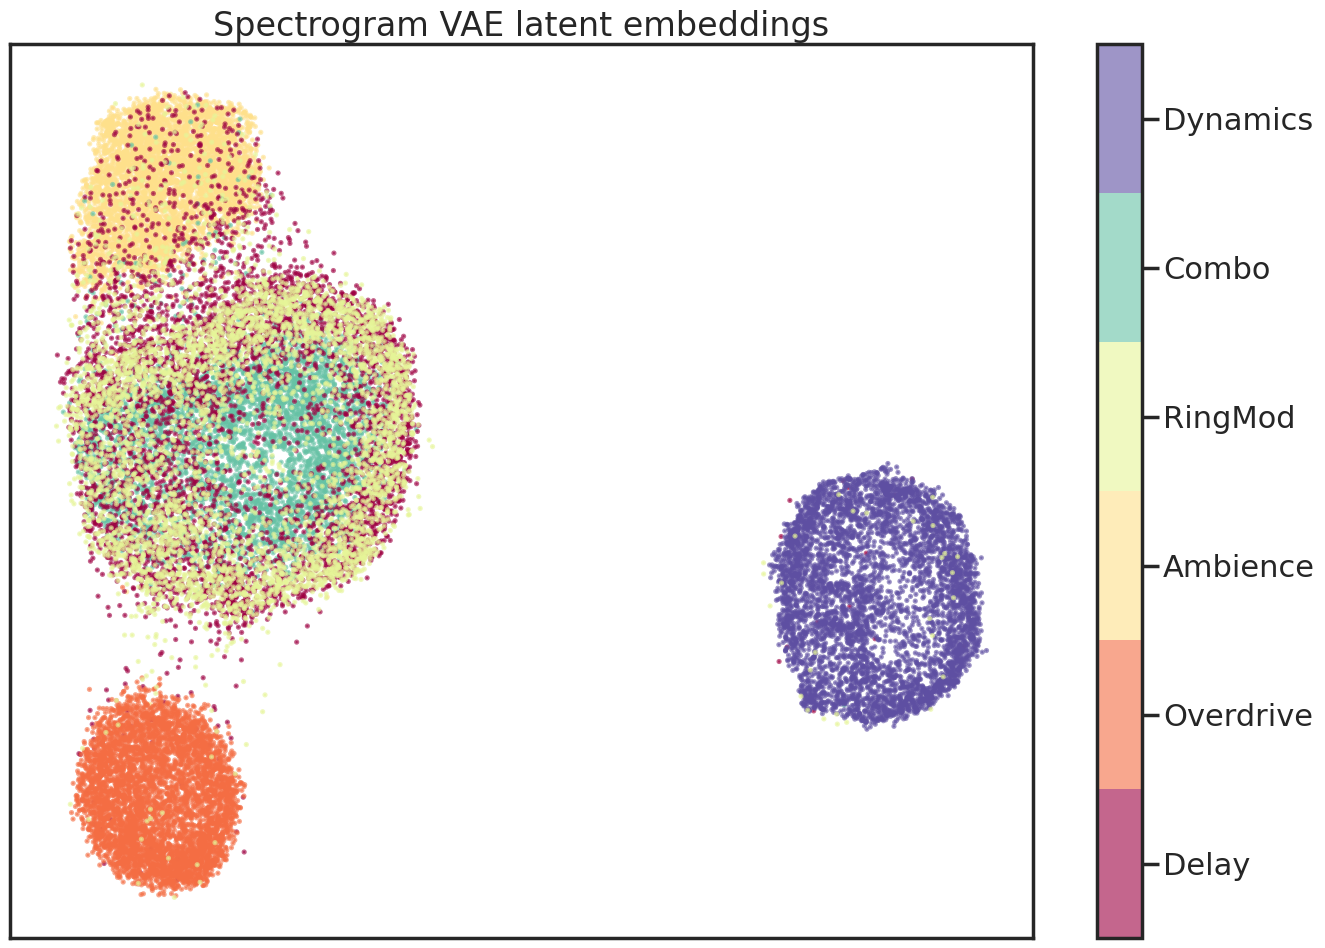

In [16]:
fig, ax = plt.subplots(1)

plt.scatter(*umap_data.T, s=3, c=plot_labels, cmap='Spectral', alpha=.6)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(num_fx+1)-0.5)
cbar.set_ticks(np.arange(num_fx))
cbar.set_ticklabels([fx_name.split()[-1] for fx_name in DAFX_TO_USE])
plt.title(f'Spectrogram VAE latent embeddings')
plt.tight_layout()
plt.savefig(f'./figures/latent_analysis/{CHECKPOINT_ID}_{num_fx}dafx.png')